In [1]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

from data_utils import load_and_preprocess_data, vectorize_text
from model_utils import evaluate_model

In [2]:
# Set random seed for reproducibility
RANDOM_STATE = 42

In [3]:
# Load and preprocess the Enron spam data
X, y, df = load_and_preprocess_data(
    '../data/enron_spam_data.csv',
    text_columns=['Subject', 'Message'],
    target_column='Spam/Ham',
    positive_class='spam',
    combine_text=True
)

Loading data from ../data/enron_spam_data.csv...
Dataset shape: (33716, 5)

Column names: ['Message ID', 'Subject', 'Message', 'Spam/Ham', 'Date']

First few rows:
   Message ID                       Subject  \
0           0  christmas tree farm pictures   
1           1      vastar resources , inc .   
2           2  calpine daily gas nomination   
3           3                    re : issue   
4           4     meter 7268 nov allocation   

                                             Message Spam/Ham        Date  
0                                                NaN      ham  1999-12-10  
1  gary , production from the high island larger ...      ham  1999-12-13  
2             - calpine daily gas nomination 1 . doc      ham  1999-12-14  
3  fyi - see note below - already done .\nstella\...      ham  1999-12-14  
4  fyi .\n- - - - - - - - - - - - - - - - - - - -...      ham  1999-12-14  

Dropped 609 rows with NaN values
Shape after dropping NaN: (33107, 5)

Combined text columns: ['

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y # Maintain class distribution in splits
)

In [5]:
X_train_vec, X_test_vec, vectorizer = vectorize_text(
    X_train, X_test,
    method='tfidf',
    max_features=5000,
    min_df=2, # Ignore terms that appear in fewer than 2 documents
    ngram_range=(1, 2) # Use unigrams and bigrams
)

Vectorizing text using TFIDF...
Training set shape: (26485, 5000)
Test set shape: (6622, 5000)
Vocabulary size: 5000


In [6]:
# Initialize and train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [7]:
# Predict on training set
y_train_pred = nb_classifier.predict(X_train_vec)

# Predict on test set
y_test_pred = nb_classifier.predict(X_test_vec)

In [8]:
# Evaluate on training set
train_metrics = evaluate_model(y_train, y_train_pred, "Training Set")

# Evaluate on test set
test_metrics = evaluate_model(y_test, y_test_pred, "Test Set")

# Print detailed classification report
print("\nDetailed Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['Ham', 'Spam']))

Training Set Metrics:
Accuracy:  0.9809
Precision: 0.9744
Recall:    0.9880
F1-Score:  0.9811
Test Set Metrics:
Accuracy:  0.9793
Precision: 0.9744
Recall:    0.9847
F1-Score:  0.9795

Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

         Ham       0.98      0.97      0.98      3299
        Spam       0.97      0.98      0.98      3323

    accuracy                           0.98      6622
   macro avg       0.98      0.98      0.98      6622
weighted avg       0.98      0.98      0.98      6622



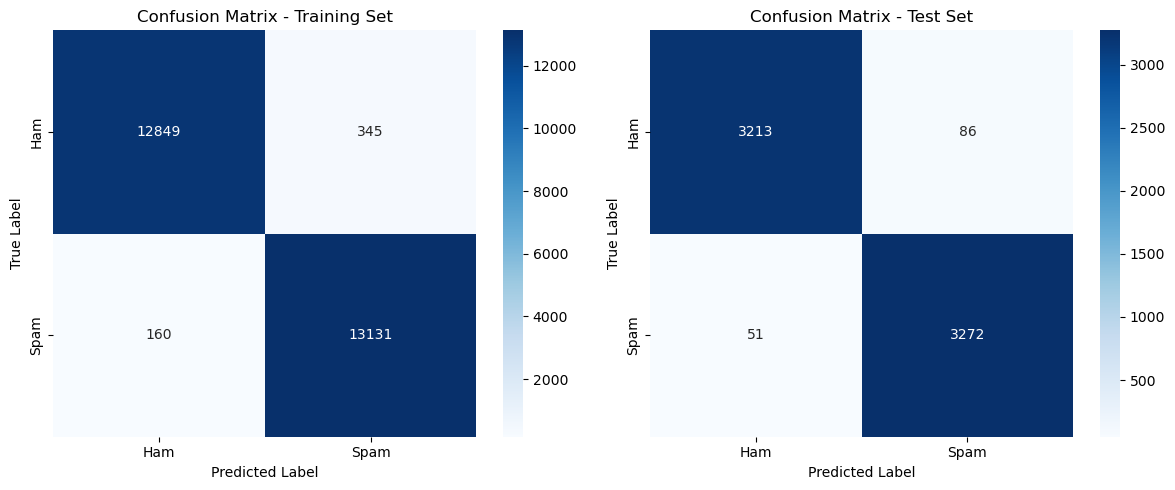

In [9]:
# Visualize with confusion matrix

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training set confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
axes[0].set_title('Confusion Matrix - Training Set')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Test set confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
axes[1].set_title('Confusion Matrix - Test Set')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [10]:
# Show top features for each class

def get_top_features(vectorizer, classifier, n=20):
    """Get top features (words) for each class."""
    feature_names = vectorizer.get_feature_names_out()
    
    # Get log probabilities for each class
    log_probs = classifier.feature_log_prob_
    
    # Top features for Ham (class 0)
    ham_indices = log_probs[0].argsort()[-n:][::-1]
    top_ham = [(feature_names[i], log_probs[0][i]) for i in ham_indices]
    
    # Top features for Spam (class 1)
    spam_indices = log_probs[1].argsort()[-n:][::-1]
    top_spam = [(feature_names[i], log_probs[1][i]) for i in spam_indices]
    
    return top_ham, top_spam

top_ham, top_spam = get_top_features(vectorizer, nb_classifier, n=15)

print("Top 15 Ham (Legitimate) Email Features:")
for i, (word, prob) in enumerate(top_ham, 1):
    print(f"{i:2d}. {word:20s} (log prob: {prob:.4f})")

print("\nTop 15 Spam Email Features:")
for i, (word, prob) in enumerate(top_spam, 1):
    print(f"{i:2d}. {word:20s} (log prob: {prob:.4f})")

Top 15 Ham (Legitimate) Email Features:
 1. the                  (log prob: -4.3908)
 2. to                   (log prob: -4.6422)
 3. and                  (log prob: -5.0625)
 4. enron                (log prob: -5.0828)
 5. ect                  (log prob: -5.1882)
 6. of                   (log prob: -5.1920)
 7. for                  (log prob: -5.2860)
 8. in                   (log prob: -5.3730)
 9. you                  (log prob: -5.4181)
10. on                   (log prob: -5.4556)
11. is                   (log prob: -5.5631)
12. will                 (log prob: -5.6872)
13. this                 (log prob: -5.6929)
14. that                 (log prob: -5.7017)
15. we                   (log prob: -5.7410)

Top 15 Spam Email Features:
 1. the                  (log prob: -4.6207)
 2. to                   (log prob: -4.7486)
 3. and                  (log prob: -4.8377)
 4. you                  (log prob: -4.8996)
 5. of                   (log prob: -4.9718)
 6. your                 (log p

In [11]:
# Test on new samples

def predict_email(text, vectorizer, classifier):
    """Predict whether a new email is spam or ham."""
    text_vec = vectorizer.transform([text])
    prediction = classifier.predict(text_vec)[0]
    probability = classifier.predict_proba(text_vec)[0]
    
    label = "SPAM" if prediction == 1 else "HAM"
    confidence = probability[prediction]
    
    return label, confidence

# Test examples
test_examples = [
    "Meeting scheduled for tomorrow at 10am in conference room B",
    "CONGRATULATIONS! You've WON $1,000,000! Click here to claim NOW!!!",
    "Hi, can you send me the quarterly report by end of day?",
    "FREE MONEY! LIMITED TIME OFFER! BUY NOW!"
]

for i, example in enumerate(test_examples, 1):
    label, confidence = predict_email(example, vectorizer, nb_classifier)
    print(f"Example {i}:")
    print(f"Text: {example}")
    print(f"Prediction: {label} (Confidence: {confidence:.2%})")

Example 1:
Text: Meeting scheduled for tomorrow at 10am in conference room B
Prediction: HAM (Confidence: 99.37%)
Example 2:
Text: CONGRATULATIONS! You've WON $1,000,000! Click here to claim NOW!!!
Prediction: SPAM (Confidence: 99.53%)
Example 3:
Text: Hi, can you send me the quarterly report by end of day?
Prediction: HAM (Confidence: 84.03%)
Example 4:
Text: FREE MONEY! LIMITED TIME OFFER! BUY NOW!
Prediction: SPAM (Confidence: 96.89%)
